# KdV equation

In [1]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *
from Error import *
from JaxUtils import *

### Setup

In [2]:
# Exact solution

def exactKdVTwoSol(x, t):
    '''
    Function taken from https://github.com/pehersto/ng/solvers/exactKdV.py
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t) # in case t is a float

    etaMat1 = k[0] * x.reshape((-1, 1)) - k[0] ** 3 * t.reshape((1, -1)) + eta[0]
    etaMat2 = k[1] * x.reshape((-1, 1)) - k[1] ** 3 * t.reshape((1, -1)) + eta[1]
    c = ((k[0] - k[1]) / (k[0] + k[1]) )** 2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2) * c)
    df = k[0] * jnp.exp(etaMat1) + k[1] * jnp.exp(etaMat2) + c * (k[0] + k[1]) * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0] ** 2 * jnp.exp(etaMat1) + k[1] ** 2 * jnp.exp(etaMat2) + c * (k[0] + k[1]) ** 2 * jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2 * jnp.divide(jnp.multiply(f, ddf) - df ** 2, f ** 2)

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]
    
    return y

In [3]:
problem_data = ProblemData(name='kdv', # problem name
                           d=1, # input dimension
                           domain=(-20, 40), # 1D: (lower, upper)
                           T=4, # final time
                           initial_fn=lambda x: exactKdVTwoSol(x, 0), # initial condition
                           N=2048, # number of spatial points
                           dt=0.01, # time step (if needed)
                          )

training_data = TrainingData(m=10, # number of neurons per layer
                             batch_size=5000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                             # scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                             #                                 transition_steps=1000, transition_begin=1000) # learning rate scheduler
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                            )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


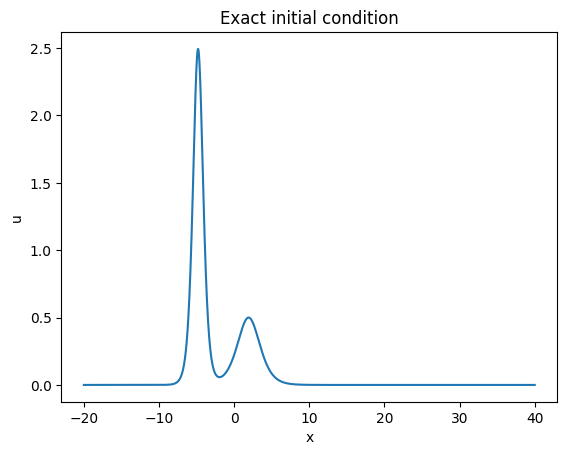

In [4]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [5]:
print(problem_data)

Problem data:
  name: kdv, d: 1, domain: (-20, 40), T: 4, N: 2048, dt: 0.01


In [6]:
print(training_data)

Training data:
  m: 10, batch size: 5000, epochs: 10000, gamma: 0.1, seed: 0, scheduler: <function exponential_decay.<locals>.schedule at 0x7f90f4874670>


### Initial fit

In [7]:
# Neural network

net = ShallowNetKdV(training_data.m, problem_data.domain[1] - problem_data.domain[0])
print(net)

ShallowNetKdV(
    # attributes
    m = 10
    L = 60
)


In [8]:
# Initial fit

initial_fit = False

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()

### Time evolution

In [9]:
theta_flat, unravel = jax.flatten_util.ravel_pytree(theta) # flatten a pytree of arrays down to a 1D array
u_fn = unraveler(net.apply, unravel) # auxiliary function that allows to evaluate the NN starting from the flattened parameters

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

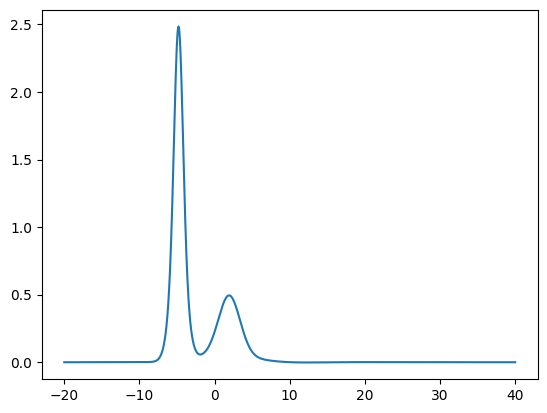

In [10]:
x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N)
u = U(theta_flat, x_plot.reshape(-1, 1))
plt.plot(x_plot, u)
plt.show()

In [11]:
# TODO: is there a way to put these functions in a separate file?

# Source term for the KdV equation
def rhs(theta_flat, x, t):
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x


@jax.jit
def M_fn(theta_flat, x):
    '''
    Assemble the M matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    return M


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F

In [12]:
def neural_galerkin(theta_flat, problem_data, n, sampler, scheme):

    print('Run time evolution...')

    if scheme == 'rk45':
        solution, timesteps = runge_kutta_scheme(theta_flat, problem_data, n, U, M_fn, F_fn, sampler)
    else:
        raise ValueError(f'Unknown solver: {scheme}.')

    return solution, timesteps

In [13]:
solution, timesteps = neural_galerkin(theta_flat=theta_flat, # initial parameters
                           problem_data=problem_data, # problem data
                           n=1000, # sample points
                           sampler='uniform',
                           scheme='rk45'
                          )

Run time evolution...
  t = 0.00000
  t = 0.03400
  t = 0.05388
  t = 0.07376
  t = 0.09518
  t = 0.11722
  t = 0.13977
  t = 0.16460
  t = 0.18969
  t = 0.21362
  t = 0.23297
  t = 0.25056
  t = 0.26236
  t = 0.27324
  t = 0.28533
  t = 0.30253
  t = 0.32336
  t = 0.34550
  t = 0.37484
  t = 0.39666
  t = 0.41804
  t = 0.43637
  t = 0.45288
  t = 0.47587
  t = 0.49788
  t = 0.52097
  t = 0.54574
  t = 0.57659
  t = 0.60181
  t = 0.62498
  t = 0.64864
  t = 0.67059
  t = 0.67610
  t = 0.68161
  t = 0.68904
  t = 0.70006
  t = 0.71438
  t = 0.72934
  t = 0.74641
  t = 0.76584
  t = 0.78385
  t = 0.80888
  t = 0.83335
  t = 0.85569
  t = 0.88257
  t = 0.90812
  t = 0.93045
  t = 0.95078
  t = 0.97475
  t = 1.00025
  t = 1.02550
  t = 1.05079
  t = 1.07322
  t = 1.08442
  t = 1.09562
  t = 1.10985
  t = 1.13001
  t = 1.15494
  t = 1.17751
  t = 1.20349
  t = 1.22958
  t = 1.25969
  t = 1.29631
  t = 1.32525
  t = 1.35298
  t = 1.38078
  t = 1.40029
  t = 1.41835
  t = 1.43906
  t = 1.4688

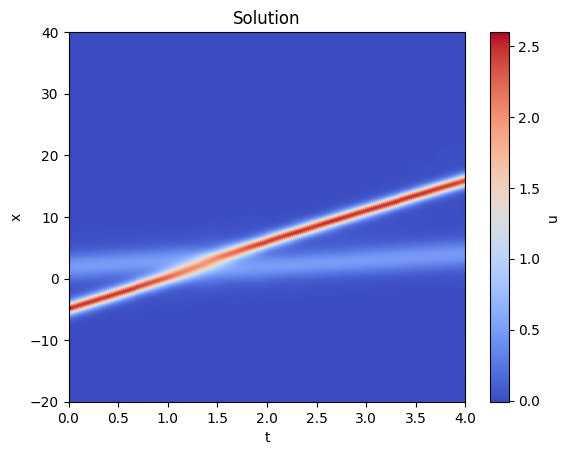

In [14]:
plot_solution(solution, timesteps, problem_data)

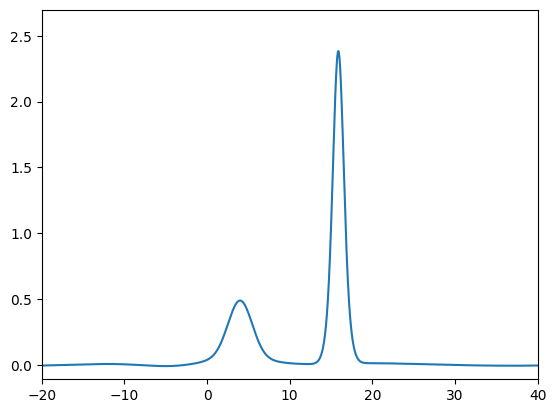

In [15]:
plot_animation(solution, timesteps, problem_data)

### Compute relative error

In [16]:
errors = compute_error(solution, timesteps, exactKdVTwoSol, problem_data)

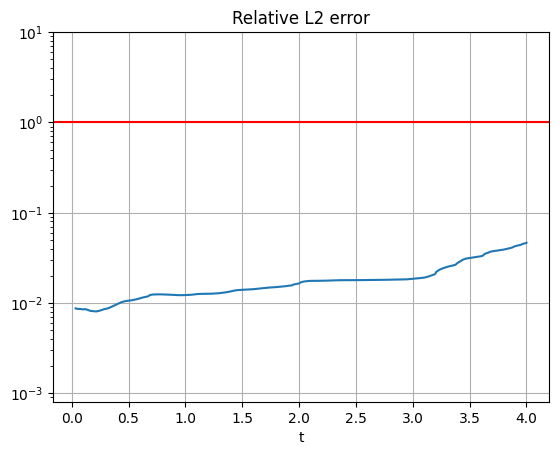

In [17]:
plot_error(errors, timesteps, 'Relative L2 error')

### Comparison with linear fitted Neural Galerkin

In [18]:
training_data_linear = TrainingData(m=30, # number of neurons per layer
                                    batch_size=5000, # batch size
                                    epochs=2000, # number of epochs
                                    gamma=0.1, # learning rate
                                    seed=0, # seed for reproducibility
                                    scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.9) # learning rate scheduler
                                    # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                                   )

net_linear = ShallowNetKdV(training_data_linear.m, problem_data.domain[1] - problem_data.domain[0])

In [19]:
initial_fit = False

if initial_fit:
    theta_linear = init_neural_galerkin(net_linear, problem_data, training_data_linear) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_linear_' + str(training_data.seed) + '.npy', theta_linear)
else:
    theta_linear = jnp.load('./data/theta_init_' + problem_data.name + '_linear_' + str(training_data.seed) + '.npy', allow_pickle=True).item()

In [20]:
# Redefine the NN to freeze the parameters of the periodic unit

theta_flat_linear, unravel = jax.flatten_util.ravel_pytree(theta_linear)
net_linear = ShallowNetKdVLinear(training_data_linear.m, problem_data.domain[1] - problem_data.domain[0], 
                                 theta_flat_linear[2*training_data_linear.m:], # weights
                                 theta_flat_linear[training_data_linear.m:2*training_data_linear.m].reshape(-1, 1) # biases
                                )
theta_flat_linear = theta_flat_linear[0:training_data_linear.m]

theta_linear = net_linear.init(jax.random.key(training_data.seed), jnp.zeros((training_data_linear.batch_size, problem_data.d)))
_, unravel = jax.flatten_util.ravel_pytree(theta_linear)
u_fn = unraveler(net_linear.apply, unravel)

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

In [21]:
# TODO: is there a way to put these functions in a separate file?

# Source term for the KdV equation
def rhs(theta_flat, x, t):
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x


@jax.jit
def M_fn(theta_flat, x):
    '''
    Assemble the M matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    return M


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F

In [22]:
solution_linear, timesteps_linear = neural_galerkin(theta_flat=theta_flat_linear, # initial parameters
                                                    problem_data=problem_data, # problem data
                                                    n=1000, # sample points
                                                    sampler='uniform',
                                                    scheme='rk45'
                                                   )

Run time evolution...
  t = 0.00000
  t = 0.02866
  t = 0.03797
  t = 0.04473
  t = 0.05090
  t = 0.05695
  t = 0.06379
  t = 0.07113
  t = 0.08048
  t = 0.09316
  t = 0.11002
  t = 0.12441
  t = 0.13742
  t = 0.15213
  t = 0.17029
  t = 0.18933
  t = 0.20957
  t = 0.23064
  t = 0.25738
  t = 0.29094
  t = 0.32996
  t = 0.37199
  t = 0.42744
  t = 0.48861
  t = 0.52962
  t = 0.56671
  t = 0.58741
  t = 0.60630
  t = 0.62577
  t = 0.64689
  t = 0.67164
  t = 0.69986
  t = 0.72820
  t = 0.73611
  t = 0.74330
  t = 0.75099
  t = 0.76293
  t = 0.78029
  t = 0.80004
  t = 0.81820
  t = 0.83527
  t = 0.85477
  t = 0.87807
  t = 0.90007
  t = 0.92130
  t = 0.94811
  t = 0.97839
  t = 1.01593
  t = 1.07175
  t = 1.12688
  t = 1.17686
  t = 1.22483
  t = 1.27915
  t = 1.34507
  t = 1.38371
  t = 1.41534
  t = 1.44441
  t = 1.47299
  t = 1.49915
  t = 1.52962
  t = 1.56426
  t = 1.60301
  t = 1.65060
  t = 1.71339
  t = 1.75759
  t = 1.79391
  t = 1.82711
  t = 1.86461
  t = 1.89821
  t = 1.9292

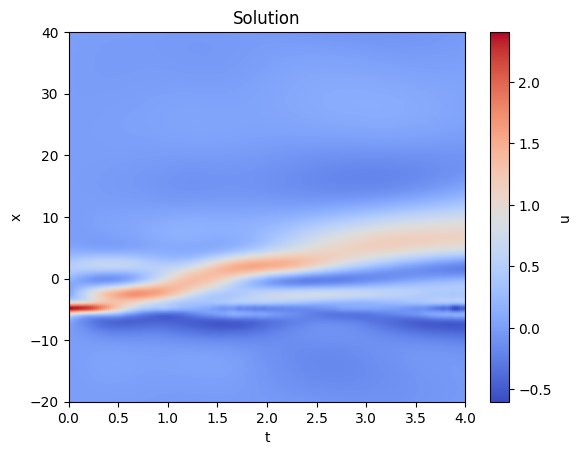

In [23]:
plot_solution(solution_linear, timesteps_linear, problem_data)

In [24]:
errors_linear = compute_error(solution_linear, timesteps_linear, exactKdVTwoSol, problem_data)

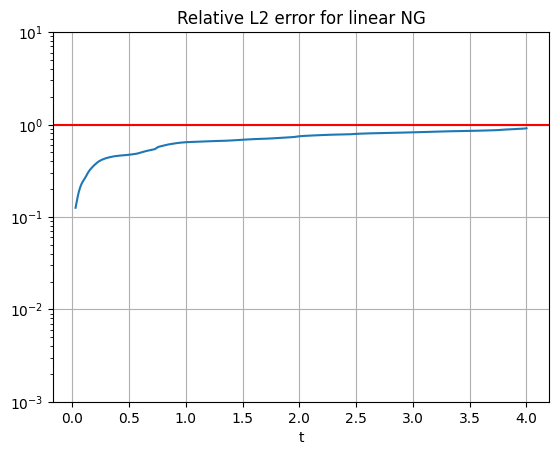

In [25]:
plot_error(errors_linear,timesteps_linear, 'Relative L2 error for linear NG')

### Comparison with linear equidistant Neural Galerkin

In [26]:
net_equi = ShallowNetKdVLinear(training_data_linear.m, problem_data.domain[1] - problem_data.domain[0], 
                               12 * jnp.ones(training_data_linear.m), # weights
                               jnp.linspace(problem_data.domain[0], problem_data.domain[1], training_data_linear.m).reshape(-1, 1) # biases
                              )

In [27]:
print(net_equi)

ShallowNetKdVLinear(
    # attributes
    m = 30
    L = 60
    w = Array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
           12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
           12., 12., 12., 12.], dtype=float32)
    b = Array([[-20.       ],
           [-17.931034 ],
           [-15.862069 ],
           [-13.793104 ],
           [-11.724137 ],
           [ -9.655172 ],
           [ -7.5862074],
           [ -5.5172415],
           [ -3.448275 ],
           [ -1.3793101],
           [  0.689656 ],
           [  2.7586212],
           [  4.827585 ],
           [  6.896551 ],
           [  8.965517 ],
           [ 11.034483 ],
           [ 13.103449 ],
           [ 15.172414 ],
           [ 17.24138  ],
           [ 19.310347 ],
           [ 21.379313 ],
           [ 23.448277 ],
           [ 25.51724  ],
           [ 27.586206 ],
           [ 29.65517  ],
           [ 31.724136 ],
           [ 33.793102 ],
           [ 35.86207  ],
     

In [28]:
initial_fit = False

if initial_fit:
    theta_equi = init_neural_galerkin(net_equi, problem_data, training_data_linear) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_equi_' + str(training_data_linear.seed) + '.npy', theta_equi)
else:
    theta_equi = jnp.load('./data/theta_init_' + problem_data.name + '_equi_' + str(training_data_linear.seed) + '.npy', allow_pickle=True).item()

In [29]:
theta_flat_equi, unravel = jax.flatten_util.ravel_pytree(theta_equi)
u_fn = unraveler(net_equi.apply, unravel)

# Define gradients
U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
U_dtheta = jax.vmap(jax.grad(u_fn), (None, 0))
U_dx = jax.vmap(gradsqz(u_fn, 1), (None, 0))
U_dddx = jax.vmap(gradsqz(gradsqz(gradsqz(u_fn, 1), 1), 1), (None, 0))

In [30]:
# TODO: is there a way to put these functions in a separate file?

# Source term for the KdV equation
def rhs(theta_flat, x, t):
    u = U(theta_flat, x)
    u_x = U_dx(theta_flat, x)
    u_xxx = U_dddx(theta_flat, x)
    return - u_xxx - 6 * u * u_x


@jax.jit
def M_fn(theta_flat, x):
    '''
    Assemble the M matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    M = jnp.mean(u_dth[:, :, jnp.newaxis] * u_dth[:, jnp.newaxis, :], axis=0)
    return M


@jax.jit
def F_fn(theta_flat, x, t):
    '''
    Assemble the F matrix.
    '''
    u_dth = U_dtheta(theta_flat, x)
    f = rhs(theta_flat, x, t) # source term
    F = jnp.mean(u_dth[:, :] * f[:, jnp.newaxis], axis=0)
    return F

In [31]:
solution_equi, timesteps_equi = neural_galerkin(theta_flat=theta_flat_equi, # initial parameters
                                                problem_data=problem_data, # problem data
                                                n=1000, # sample points
                                                sampler='uniform',
                                                scheme='rk45'
                                               )

Run time evolution...
  t = 0.00000
  t = 0.04243
  t = 0.14964
  t = 0.24880
  t = 0.35751
  t = 0.46148
  t = 0.51550
  t = 0.56449
  t = 0.61631
  t = 0.66655
  t = 0.72388
  t = 0.78744
  t = 0.85406
  t = 0.93115
  t = 1.00640
  t = 1.07850
  t = 1.14661
  t = 1.21179
  t = 1.27800
  t = 1.37027
  t = 1.45632
  t = 1.51475
  t = 1.56736
  t = 1.62690
  t = 1.69130
  t = 1.76464
  t = 1.83888
  t = 1.91268
  t = 1.98657
  t = 2.06524
  t = 2.15066
  t = 2.23770
  t = 2.32890
  t = 2.39503
  t = 2.45477
  t = 2.51044
  t = 2.56733
  t = 2.62767
  t = 2.68556
  t = 2.74383
  t = 2.76398
  t = 2.78033
  t = 2.79519
  t = 2.81119
  t = 2.83050
  t = 2.85319
  t = 2.88277
  t = 2.92097
  t = 2.96464
  t = 3.01337
  t = 3.06724
  t = 3.11788
  t = 3.16606
  t = 3.22334
  t = 3.28659
  t = 3.34545
  t = 3.40139
  t = 3.45615
  t = 3.51487
  t = 3.57552
  t = 3.64368
  t = 3.71523
  t = 3.78016
  t = 3.84333
  t = 3.90534
  t = 3.96190


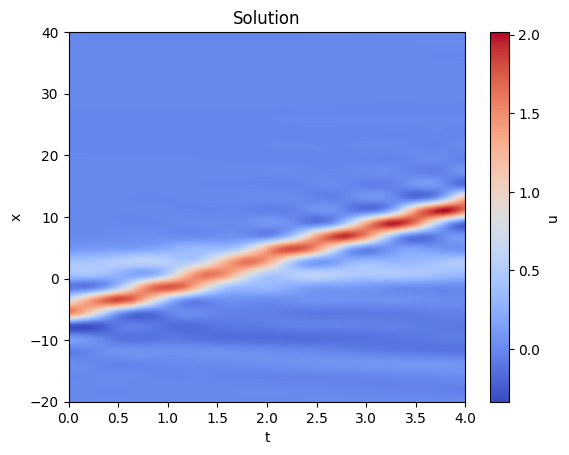

In [32]:
plot_solution(solution_equi, timesteps_equi, problem_data)

In [33]:
errors_equi = compute_error(solution_equi, timesteps_equi, exactKdVTwoSol, problem_data)

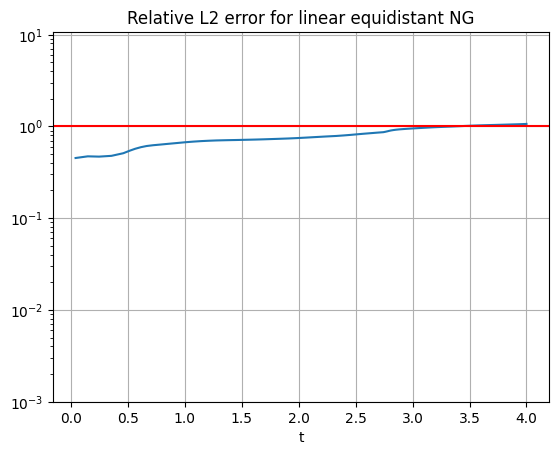

In [34]:
plot_error(errors_equi, timesteps_equi, 'Relative L2 error for linear equidistant NG')

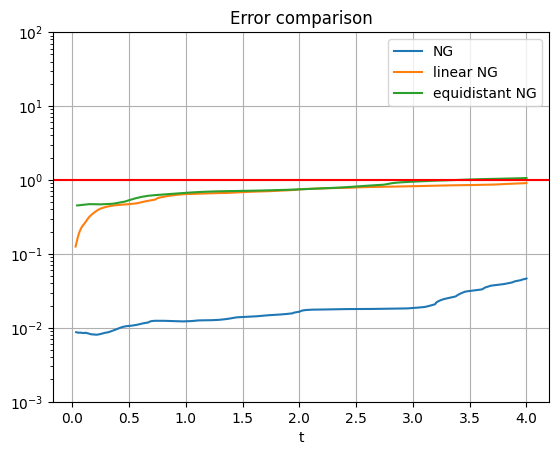

In [35]:
errors_list = [errors, errors_linear, errors_equi]
timesteps_list = [timesteps, timesteps_linear, timesteps_equi]
plot_error_comparison(errors_list, timesteps_list)